In [1]:
import pandas as pd
import kagglehub
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download latest dataset and load it in Pandas 

In [2]:
#Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", path)

100%|██████████| 11.9M/11.9M [00:00<00:00, 12.5MB/s]

Extracting files...


Path to dataset files: C:\Users\s3phi\.cache\kagglehub\datasets\nelgiriyewithana\world-stock-prices-daily-updating\versions\351


In [7]:
#Load Data in pandas
data_path = path+"\World-Stock-Prices-Dataset.csv"
data = pd.read_csv(data_path)

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\s3phi\AppData\Local\Temp\ipykernel_24620\3204793938.py:2: SyntaxWarning: invalid escape sequence '\W'
  data_path = path+"\World-Stock-Prices-Dataset.csv"


# Exploring Data

In [8]:
#Check data content
data.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-16 00:00:00-04:00,6.320000,6.435400,6.220000,6.340000,12087274.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-16 00:00:00-04:00,118.070000,118.239998,116.010002,117.169998,42968300.0,0.0,0.0,amd,AMD,technology,usa,NaN
2,2025-05-16 00:00:00-04:00,10.050000,10.220000,10.010000,10.200000,5015027.0,0.0,0.0,zoominfo,ZI,technology,usa,NaN
3,2025-05-16 00:00:00-04:00,71.860001,72.260002,71.430000,72.000000,18426600.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
4,2025-05-16 00:00:00-04:00,1193.140015,1196.500000,1179.390015,1191.530029,4683800.0,0.0,0.0,netflix,NFLX,entertainment,usa,NaN
5,2025-05-16 00:00:00-04:00,23.799999,23.889999,23.750000,23.850000,18663200.0,0.0,0.0,foot locker,FL,footwear,usa,NaN
6,2025-05-16 00:00:00-04:00,24.010000,24.150000,23.889999,24.030001,864900.0,0.0,0.0,philips,PHG,technology,netherlands,NaN
7,2025-05-16 00:00:00-04:00,24.540001,24.639999,24.540001,24.580000,16043900.0,0.0,0.0,nordstrom,JWN,retail,usa,NaN
8,2025-05-16 00:00:00-04:00,149.429993,153.279999,148.949997,153.110001,3556300.0,0.0,0.0,3m,MMM,manufacturing,usa,NaN
9,2025-05-16 00:00:00-04:00,231.509995,232.490005,226.649994,229.509995,2270900.0,0.0,0.0,fedex,FDX,logistics,usa,NaN


In [9]:
#Check data types
data.dtypes

Date              object
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
Dividends        float64
Stock Splits     float64
Brand_Name        object
Ticker            object
Industry_Tag      object
Country           object
Capital Gains    float64
dtype: object

In [10]:
#Create DataFrame
df = pd.DataFrame(data)

In [11]:
#Filter Brand_Name by apple and filter columns by Date, Close, Brand_Name
df_apple = df.loc[df["Brand_Name"] == "apple", ["Date", "Close", "Brand_Name"]]
display(df_apple)

,Date,Close,Brand_Name
58,2025-05-16 00:00:00-04:00,211.259995,apple
87,2025-05-16 00:00:00-04:00,211.259995,apple
156,2025-05-15 00:00:00-04:00,211.449997,apple
183,2025-05-14 00:00:00-04:00,212.330002,apple
277,2025-05-13 00:00:00-04:00,212.929993,apple
...,...,...,...
307632,2000-01-07 00:00:00-05:00,0.754065,apple
307682,2000-01-06 00:00:00-05:00,0.719961,apple
307717,2000-01-05 00:00:00-05:00,0.788168,apple
307746,2000-01-04 00:00:00-05:00,0.776801,apple


In [12]:
df_apple.dtypes

Date           object
Close         float64
Brand_Name     object
dtype: object

In [ ]:
# try:
#     df_apple['Date'] = pd.to_datetime(df_apple['Date'], utc=True)  #Parsing into UTC
# except Exception as e:
#     print("Error converting 'Date' column:", e)

# df_apple.head(10)

,Date,Close,Brand_Name
35,2025-05-15 04:00:00+00:00,211.449997,apple
69,2025-05-14 04:00:00+00:00,212.330002,apple
159,2025-05-13 04:00:00+00:00,212.929993,apple
180,2025-05-12 04:00:00+00:00,210.789993,apple
269,2025-05-05 04:00:00+00:00,198.889999,apple
300,2025-05-02 04:00:00+00:00,205.350006,apple
395,2025-05-02 04:00:00+00:00,205.350006,apple
430,2025-05-01 04:00:00+00:00,213.320007,apple
518,2025-04-30 04:00:00+00:00,212.500000,apple
545,2025-04-29 04:00:00+00:00,211.210007,apple


In [13]:
df_apple_preproc = df_apple.rename(columns={"Date": "timestamp", "Close": "target", "Brand_Name": "item_id"})
df_apple_preproc.head(5)

,timestamp,target,item_id
58,2025-05-16 00:00:00-04:00,211.259995,apple
87,2025-05-16 00:00:00-04:00,211.259995,apple
156,2025-05-15 00:00:00-04:00,211.449997,apple
183,2025-05-14 00:00:00-04:00,212.330002,apple
277,2025-05-13 00:00:00-04:00,212.929993,apple


In [14]:
df_apple_preproc["item_id"] = df_apple_preproc['item_id'].astype("string")
df_apple_preproc["timestamp"] = df_apple_preproc['timestamp'].astype("string")
df_apple_preproc.dtypes

timestamp    string[python]
target              float64
item_id      string[python]
dtype: object

In [16]:
timecut = df_apple_preproc["timestamp"].str.slice(stop=10) #Cut hh:mm:ss and timezone
timecut

58        2025-05-16
87        2025-05-16
156       2025-05-15
183       2025-05-14
277       2025-05-13
             ...    
307632    2000-01-07
307682    2000-01-06
307717    2000-01-05
307746    2000-01-04
307787    2000-01-03
Name: timestamp, Length: 6430, dtype: string

In [18]:
df_apple_preproc["timestamp"] = timecut
df_apple_preproc

,timestamp,target,item_id
58,2025-05-16,211.259995,apple
87,2025-05-16,211.259995,apple
156,2025-05-15,211.449997,apple
183,2025-05-14,212.330002,apple
277,2025-05-13,212.929993,apple
...,...,...,...
307632,2000-01-07,0.754065,apple
307682,2000-01-06,0.719961,apple
307717,2000-01-05,0.788168,apple
307746,2000-01-04,0.776801,apple


In [19]:
df_apple_preproc["timestamp"] = pd.to_datetime(timecut) #convert string into datetime64
df_apple_preproc.dtypes

timestamp    datetime64[ns]
target              float64
item_id      string[python]
dtype: object

In [20]:
df_apple_preproc.head(10)

,timestamp,target,item_id
58,2025-05-16,211.259995,apple
87,2025-05-16,211.259995,apple
156,2025-05-15,211.449997,apple
183,2025-05-14,212.330002,apple
277,2025-05-13,212.929993,apple
314,2025-05-12,210.789993,apple
386,2025-05-05,198.889999,apple
430,2025-05-02,205.350006,apple
514,2025-05-02,205.350006,apple
541,2025-05-01,213.320007,apple


In [21]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

load_data = TimeSeriesDataFrame.from_data_frame(
    df_apple_preproc,
    id_column="item_id",
    timestamp_column="timestamp"
)
load_data.head()

target
item_id timestamp             
apple   2025-05-16  211.259995
        2025-05-16  211.259995
        2025-05-15  211.449997
        2025-05-14  212.330002
        2025-05-13  212.929993

In [22]:
prediction_length = 10
train_data, test_data = load_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="w").fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\predictor.py:198: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)
Frequency 'w' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250519_085818'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.23 GB / 15.70 GB (7.8%)
Disk Space Avail:   75.29 GB / 475.50 GB (15.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_n

	14.61   s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 14.62 s
Best model: Chronos[bolt_small]


In [23]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


AttributeError: 'DataFrame' object has no attribute 'item_ids'

# Test Data

In [27]:
df_apple_preproc.to_csv('apple-out.csv', index=False)

In [28]:
%matplotlib inline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame.from_path(
    "apple-out.csv"
)
data.head()

target
item_id timestamp             
apple   2025-05-16  211.259995
        2025-05-16  211.259995
        2025-05-15  211.449997
        2025-05-14  212.330002
        2025-05-13  212.929993

In [29]:
prediction_length = 20
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="w").fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\predictor.py:198: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)
Frequency 'w' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250519_090728'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.46 GB / 15.70 GB (9.3%)
Disk Space Avail:   75.25 GB / 475.50 GB (15.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_n

data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


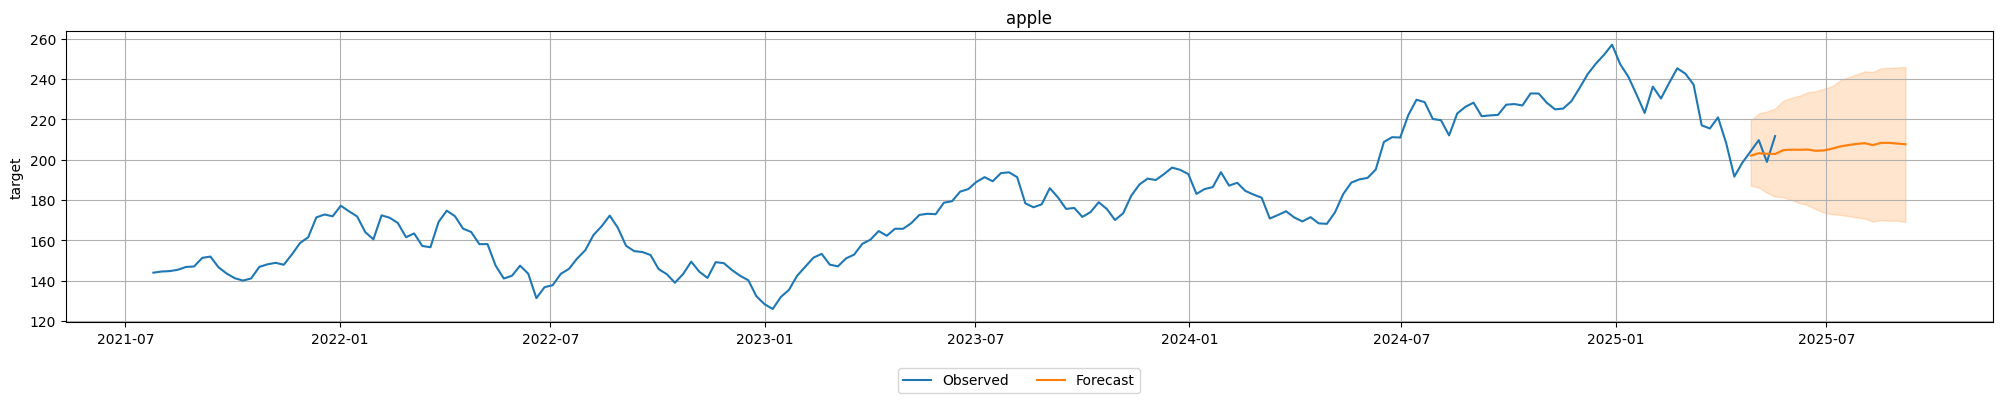

In [31]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);